In [12]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

## Daten auslesen



In [5]:
train=pd.read_csv(r'C:\Users\i518095\Documents\GitHub\DHBW_Daten_Analyse\Data\train.csv')
test=pd.read_csv(r'C:\Users\i518095\Documents\GitHub\DHBW_Daten_Analyse\Data\test.csv')

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (891, 12)
Testing data shape:  (418, 11)


## Die ersten paar Zeilen des Trainingsdatensatzes

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Untersuchung der Target Variable

>Für jeden Passagier im Testdatensatz müssen wir ein Modell erstellen, das vorhersagt, ob die Passagiere den Untergang der Titanic überlebt haben oder nicht. Überlebt ist also die abhängige Variable im Datensatz. Untersuchen wir nun die Verteilung der abhängige Variable

In [8]:
 train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

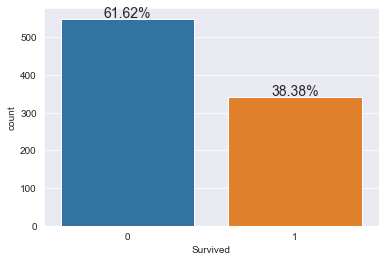

In [9]:
s = sns.countplot(x = 'Survived',data = train)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

Hier:
* 0: nicht überlebt 
* 1: überlebt 



# Erkennung fehlender Werte

>Der erste Schritt ist die Ermittlung der Anzahl/des Prozentsatzes der fehlenden Werte in jeder Spalte des Datensatzes. Dies vermittelt einen Eindruck von der Verteilung der fehlenden Werte.

In [4]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
# One of the best notebooks on getting started with a ML problem.

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Dein Datensatz hat " + str(df.shape[1]) + " columns.\n"      
            "Es gibt " + str(mis_val_table_ren_columns.shape[0]) +
              " Spalten mit missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns



In [6]:
train_missing= missing_values_table(train)
train_missing

Dein Datensatz hat 12 columns.
Es gibt 3 Spalten mit missing values.


,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [5]:
test_missing= missing_values_table(test)
test_missing

Dein Datensatz hat 11 columns.
Es gibt 3 Spalten mit missing values.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


## Visuelle Erkennung fehlender Daten mit der Missingno-Bibliothek


<AxesSubplot:>

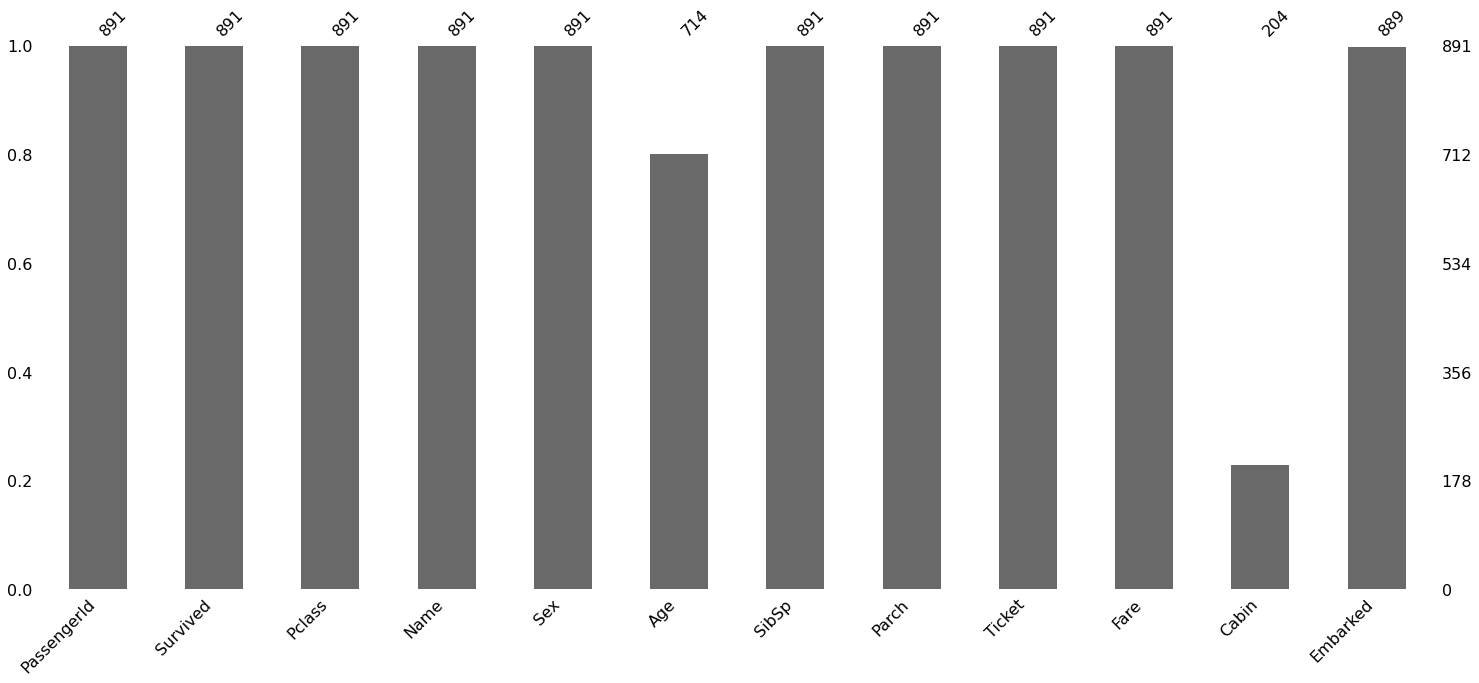

In [6]:
msno.bar(train)

>Das obige Balkendiagramm gibt einen schnellen grafischen Überblick über die Vollständigkeit des Datensatzes. Wir sehen, dass die Spalten Alter, Kabine und Einschiffung fehlende Werte aufweisen. 

## Suche nach dem Grund für fehlende Daten mithilfe einer Matrixdarstellung 

<AxesSubplot:>

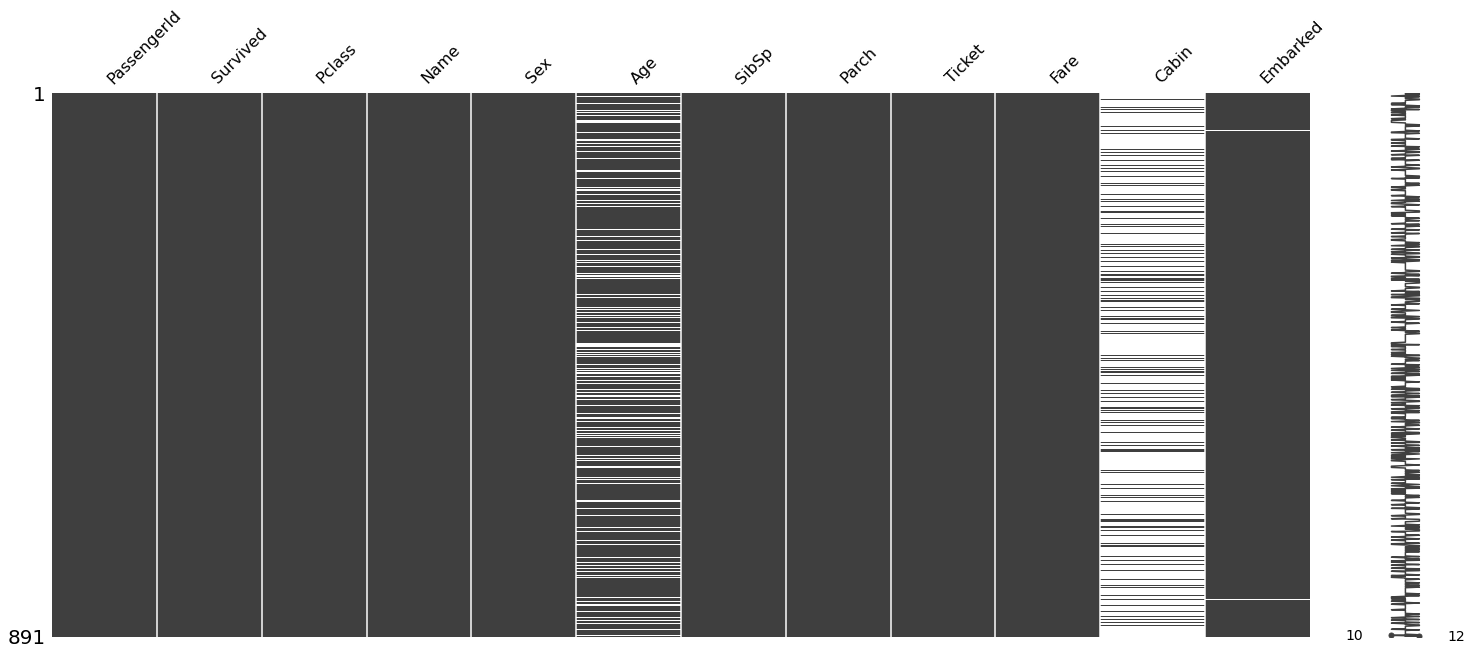

In [7]:
msno.matrix(train)

>* Die Spalte "Embarked" weist nur sehr wenige fehlende Werte auf und scheint mit keiner anderen Spalte korreliert zu sein. Daher kann die Fehlmenge in der Spalte "Embarked" als "Missing Completely at Random" eingestuft werden.
* Sowohl in der Spalte "Alter" als auch in der Spalte "Cabin" gibt es viele fehlende Werte, was ein Fall von MAR sein könnte, da wir den Grund für die fehlenden Daten in diesen Spalten nicht direkt beobachten können.

Mit dem missingno-Paket können wir das Diagramm auch nach einer bestimmten Spalte sortieren. Sortieren wir die Werte nach den Spalten "Age" und "Cabin", um zu sehen, ob es ein Muster bei den fehlenden Werten gibt

<AxesSubplot:>

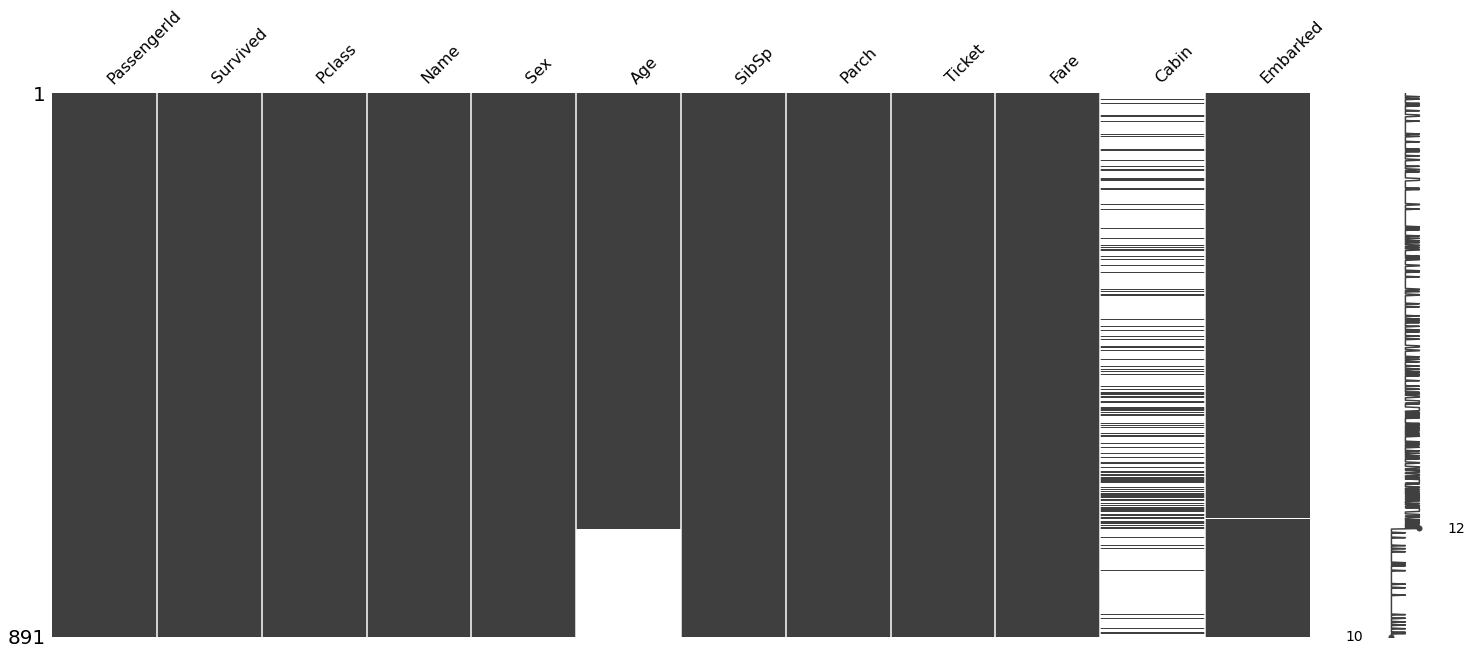

In [8]:
#sorted by Age
sorted = train.sort_values('Age')
msno.matrix(sorted)

## Löschen von fehlenden Daten

In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
train_1 = train.copy()
train_1['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.69911764705882


### Listenweises Löschen/ Dropping rows

>Bei der listenweisen Löschung werden vollständige Zeilen (die die fehlenden Werte enthalten) gelöscht. Daher wird sie auch als vollständige Falllöschung bezeichnet.


In [11]:
#Drop rows which contains any NaN or missing value for Age column
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

0

>Ein großer Nachteil des listenweisen Löschens ist, dass ein großer Teil der Daten und damit eine Menge Informationen verloren gehen. Daher ist es ratsam, diese Methode nur zu verwenden, wenn die Anzahl der fehlenden Werte sehr gering ist.


### Weglassen ganzer Spalten 

Wenn eine Spalte viele fehlende Werte enthält, z. B. mehr als 80 %, und das Merkmal nicht signifikant ist, sollten Sie dieses Merkmal vielleicht löschen. Aber auch hier gilt, dass es keine gute Methode ist, Daten zu löschen.


## Imputation


In [12]:
# imputing with a constant

from sklearn.impute import SimpleImputer
train_constant = train.copy()
#setting strategy to 'constant' 
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()
# Die ersten paar Zeilen des Trainingsdatensatzes
train_constant.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,missing_value,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,missing_value,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,missing_value,S


In [13]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [14]:
train_most_frequent.isnull().sum()

# Die ersten paar Zeilen des Trainingsdatensatzes
train_most_frequent.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S


## Fortgeschrittene Imputationstechniken 

Bei fortgeschrittenen Imputationsverfahren werden Algorithmen des maschinellen Lernens verwendet, um die fehlenden Werte in einem Datensatz zu imputieren, im Gegensatz zu den vorherigen Verfahren, bei denen wir andere Spaltenwerte zur Vorhersage der fehlenden Werte verwendet haben. In dieser Vorlesung werden wir uns  folgende Technike ansehen:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)

### K-Nearest Neighbor Imputation

Bei [KNNImputer class](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) wird jedes fehlende Merkmal mit Hilfe der Werte von n_Nächsten Nachbarn, die einen Wert für das Merkmal haben, unterstellt. Die Merkmale der Nachbarn werden gleichmäßig gemittelt oder nach der Entfernung zu jedem Nachbarn gewichtet. 

In [15]:
train_knn = train.copy(deep=True)

In [16]:
from sklearn.impute import KNNImputer
train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [17]:
train_knn['Age'].isnull().sum()

# Die ersten paar Zeilen des Trainingsdatensatzes
train_knn.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Lösung Aufgabe:

### Lesen der Test-Daten

In [17]:
path: str = r"C:\Users\i518095\Documents\GitHub\DHBW_Daten_Analyse\Data\test.csv"
test_daten: DataFrame = pd.read_csv(path)

# Anzeigen des Shapes der Daten
print('Testing data shape: ', test.shape)

Testing data shape:  (418, 11)


## Anzeigen der ersten Zeilen der Testdaten

In [19]:
test_daten.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Untersuchen der Targetvariable

In [ ]:
test_daten['Survived'].value_counts()

## Anzeigen der Daten

In [ ]:
s = sns.countplot(x='Survived', data=test_daten)
sizes: List = []

for patch in s.patches:
    height = patch.get_height()
    sizes.append(height)
    s.text(patch.get_x() + patch.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14)

## Erkennung fehlender Werte

In [ ]:
# Hilfsfunktion um fehlende Werte zu erkennen

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Dein Datensatz hat " + str(df.shape[1]) + " columns.\n"      
            "Es gibt " + str(mis_val_table_ren_columns.shape[0]) +
              " Spalten mit missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

test_missing: DataFrame = missing_values_table(test_daten)
test_missing


## Visuelle Erkennung fehlender Daten mit der Missingno-Bibliothek

In [ ]:
# Barchart für Fehlende Daten
msno.bar(test_daten)

## Suche nach dem Grund für fehlende Daten mithilfe einer Matrixdarstellung


In [ ]:
msno.matrix(test_daten)

# Ansicht der matrix sortiert nach Age

In [ ]:
sorted = test_daten.sort_values('Age')
msno.matrix(sorted)

Es ist kein direkter Zusammenhang zwischen den Fehlenden Daten bei 'Age' und 'Cabin' zu erkennen.

## Löschen von Fehlenden Daten

In [ ]:
test_daten.isnull().sum()

## Zeilenweises Löschen der Daten

In [ ]:
test_daten_copy = test_daten.copy()
test_daten_copy['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

In [ ]:
test_daten_copy.dropna(subset=['Age'],how='any',inplace=True)
test_daten_copy['Age'].isnull().sum()

## Anzeigen der Daten

In [ ]:
s = sns.countplot(x='Survived', data=test_daten)
sizes: List = []

for patch in s.patches:
    height = patch.get_height()
    sizes.append(height)
    s.text(patch.get_x() + patch.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14)

## Erkennung fehlender Werte

In [23]:
# Hilfsfunktion um fehlende Werte zu erkennen

def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Dein Datensatz hat " + str(df.shape[1]) + " columns.\n"      
            "Es gibt " + str(mis_val_table_ren_columns.shape[0]) +
              " Spalten mit missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

test_missing: DataFrame = missing_values_table(test_daten)
test_missing


Dein Datensatz hat 11 columns.
Es gibt 3 Spalten mit missing values.


,Missing Values,% of Total Values
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


## Visuelle Erkennung fehlender Daten mit der Missingno-Bibliothek

<AxesSubplot:>

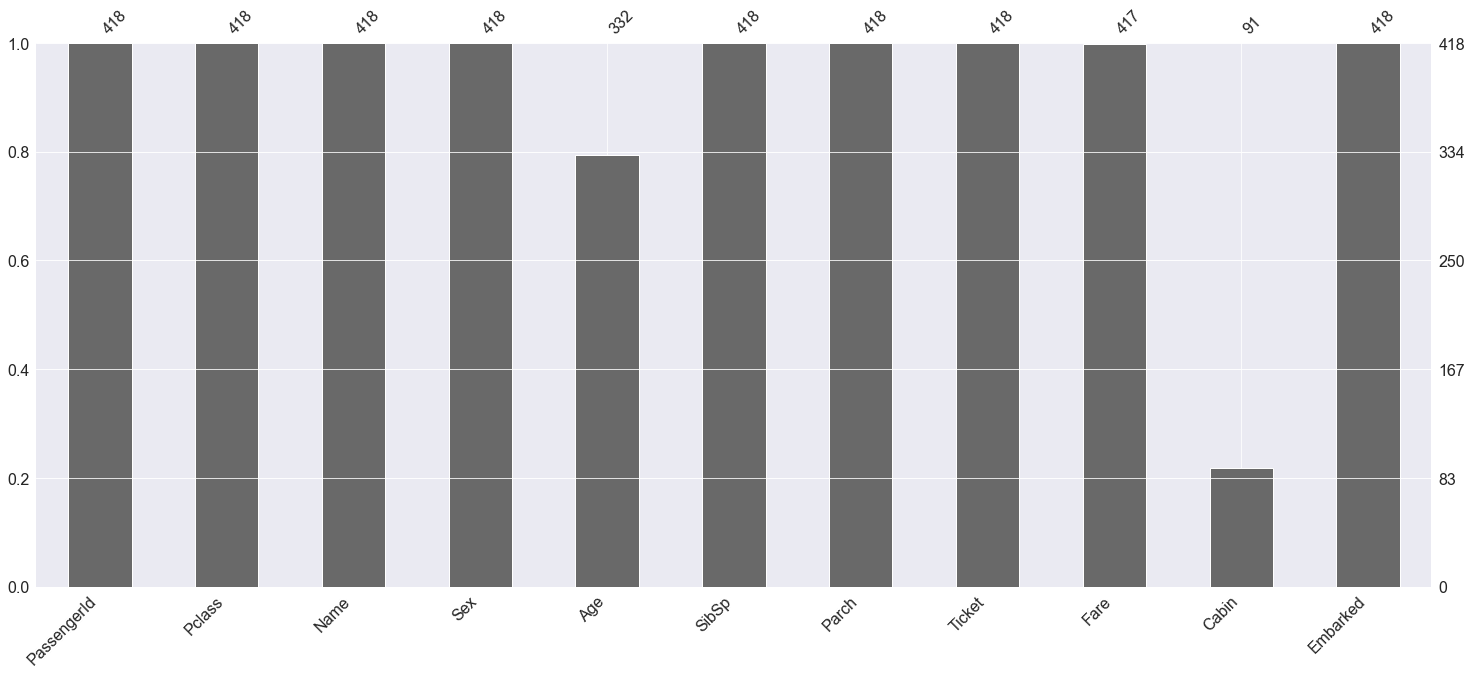

In [28]:
# Barchart für Fehlende Daten
msno.bar(test_daten)

## Suche nach dem Grund für fehlende Daten mithilfe einer Matrixdarstellung


<AxesSubplot:>

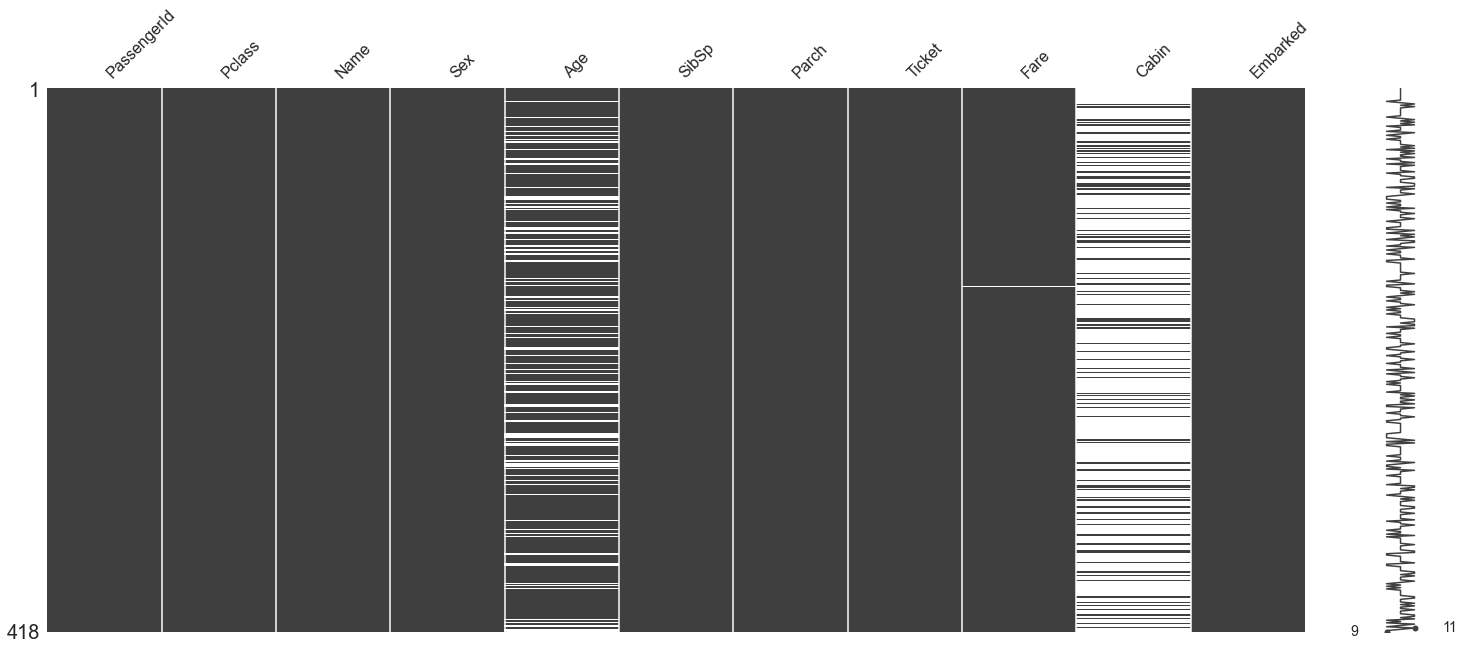

In [29]:
msno.matrix(test_daten)

# Ansicht der matrix sortiert nach Age

<AxesSubplot:>

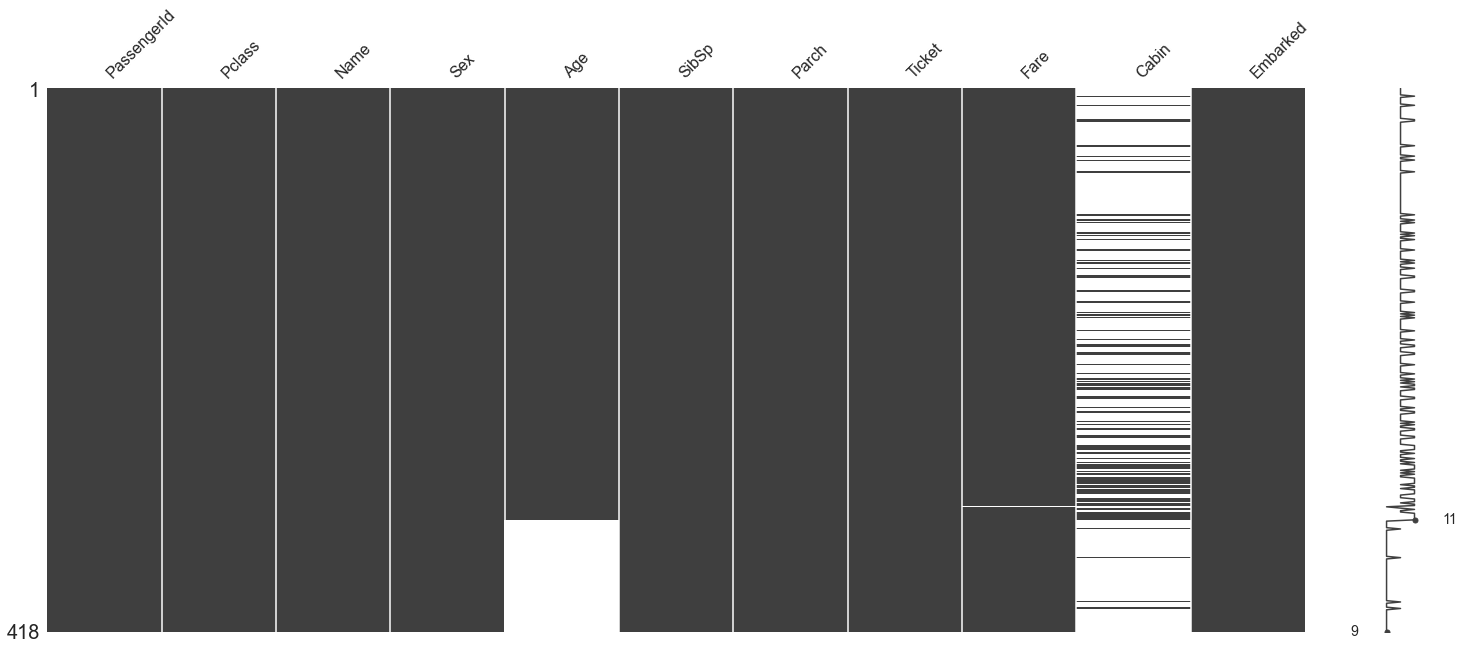

In [31]:
sorted = test_daten.sort_values('Age')
msno.matrix(sorted)

Es ist kein direkter Zusammenhang zwischen den Fehlenden Daten bei 'Age' und 'Cabin' zu erkennen.

## Löschen von Fehlenden Daten

In [34]:
test_daten.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Zeilenweises Löschen der Daten

In [35]:
test_daten_copy = test_daten.copy()
test_daten_copy['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

30.272590361445783

In [36]:
test_daten_copy.dropna(subset=['Age'],how='any',inplace=True)
test_daten_copy['Age'].isnull().sum()

0